In [1]:
!git clone https://github.com/ezzbreezn/importance_sampling.git
!mv importance_sampling/* .
!rm -r importance_sampling

Cloning into 'importance_sampling'...
remote: Enumerating objects: 79, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 79 (delta 43), reused 44 (delta 19), pack-reused 0
Receiving objects: 100% (79/79), 326.58 KiB | 4.30 MiB/s, done.
Resolving deltas: 100% (43/43), done.


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from torch_importance_sampling_tr import VarReductionCondition, get_g
from common_utils import Accumulator

def train_batch_is(model,
                x_batch,
                y_batch,
                loss_fn,
                optimizer,
                accumulator,
                weights):

    flag = False
    model.train()
    optimizer.zero_grad()

    batch_size = x_batch.shape[0]

    #selected_batch_size = int(batch_size / presample)

    #if condition.satisfied :
    #    #print("condition satisfied")
    #    output = model(x_batch)
    #    g_i_norm = get_g(output, y_batch  )
    #    condition.update(g_i_norm)
    #    flag = True
    #else:
    #    #print("condition not satisfied")
    #    g_i_norm = np.ones(batch_size)




    output = model(x_batch)
    loss = loss_fn(output, y_batch) * weights
    loss = loss.mean()

    loss.backward()

    optimizer.step()



    n = len(output)
    with torch.no_grad():
        batch_loss = loss.mean().cpu().item()
        batch_acc_sum = (output.argmax(dim=1) == y_batch).sum().cpu().item()/n


    accumulator.average(
        train_loss = ( batch_loss, n) ,
        train_acc = ( batch_acc_sum, n) ,
        train_uniform_cnt = flag)


In [49]:
def train_full(model, train_dataloader, loss_fn, optimizer, n_epochs, eval = None, callback=None):
    epochs = tqdm(range(n_epochs), desc='Epochs', leave=True)
    X = torch.tensor(train_dataloader.dataset.data, dtype=torch.float32).transpose(1, -1)
    y = torch.tensor(train_dataloader.dataset.targets).long()
    batch_size = int( train_dataloader.batch_size)
    n_batches = len(train_dataloader)

    if callback :
        callback.setMeta(
            large_batch = batch_size,
            n_epochs = n_epochs)



    sample_weight_logit = torch.ones(len(train_dataloader))

    for i_epoch in epochs:
        accum = Accumulator()

        probs = F.softmax(sample_weight_logit, dim=-1)
        batch_indices = torch.multinomial(probs, n_batches * batch_size, replacement=True).view(n_batches, batch_size)
        importance_sampling_weights = 1/(probs[batch_indices]*n_batches*batch_size)
        importance_sampling_weights /= importance_sampling_weights.sum(dim=1, keepdim=True)
        importance_sampling_weights = importance_sampling_weights.to(device)



        for batch_idx in range(len(train_dataloader)):
            train_batch_is( model,
                            X[batch_indices[batch_idx]].to(model.device),
                            y[batch_indices[batch_idx]].to(model.device),
                            loss_fn,
                            optimizer,
                            accum,
                            importance_sampling_weights[batch_idx])
        model.eval()
        test_loss = 0
        correct = 0

        with torch.no_grad():
            losses = torch.zeros(n_batches * batch_size)
            for batch_idx in range(len(train_dataloader)):
                output = model(X[batch_idx * batch_size : (batch_idx + 1) * batch_size].to(model.device))
                losses[batch_idx * batch_size : (batch_idx + 1) * batch_size] = F.nll_loss(output, y[batch_idx * batch_size : (batch_idx + 1) * batch_size].to(model.device), reduction='none').cpu()


            alpha = 1
            sample_weight_logit = losses*alpha
            # clip logits for stability
            percentiles = np.percentile(sample_weight_logit, [10, 90])
            sample_weight_logit = torch.clamp(sample_weight_logit, percentiles[0], percentiles[1])


        if callback :
            val_scores = eval(model) if eval else {}
            #print(condition.string + f" n_un={callback.n_un[-1]}")
            cb_dict = callback(model,  **accum.getAll(), **val_scores)
            epochs.set_postfix(cb_dict)





In [50]:
def evaluate(model, dataloader, loss_fn):
    model.eval()
    logits = []
    targets = []
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            output = model(X_batch.to(model.device)).cpu()
            logits.append(output)
            targets.append(y_batch)
    logits = torch.cat(logits)
    targets = torch.cat(targets)
    loss = loss_fn(logits, targets).mean().item()
    acc = (logits.argmax(dim=1) == targets).sum().item() / len(targets)
    return loss, acc



In [51]:
from data_loaders import train_val_dataloader, test_dataloader

train_dataloader, val_dataloader = train_val_dataloader(batch_size=120)#128*3
test_loader = test_dataloader(batch_size=120)


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [52]:
%load_ext autoreload

%aimport common_utils
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
%autoreload 1
from models import ResNet50
from common_utils import UnCallBack

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = ResNet50()
model.to(device)
model.device = device

loss_fn = nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3 )

callback = UnCallBack( info_list = ['train_loss', 'train_acc', 'train_w_loss', 'val_loss', 'val_acc', 'train_uniform_cnt'])

def eval_callback(model):
    loss, acc =evaluate(model, val_dataloader, loss_fn)
    return {"val_loss": loss, "val_acc": acc}

train_full(model, train_dataloader, loss_fn, optimizer, n_epochs=40, eval=eval_callback, callback=callback)
callback.save("callback")

cuda


Epochs:   0%|          | 0/40 [00:00<?, ?it/s]

In [ ]:
#from common_utils import UnCallBack
#callback = UnCallBack.load("callback.pickle")
#callback

In [ ]:

loss, acc = evaluate(model, test_loader, loss_fn)
print(f'ResNet50, test loss: {loss}')
print(f'ResNet50, test accuracy: {acc}')

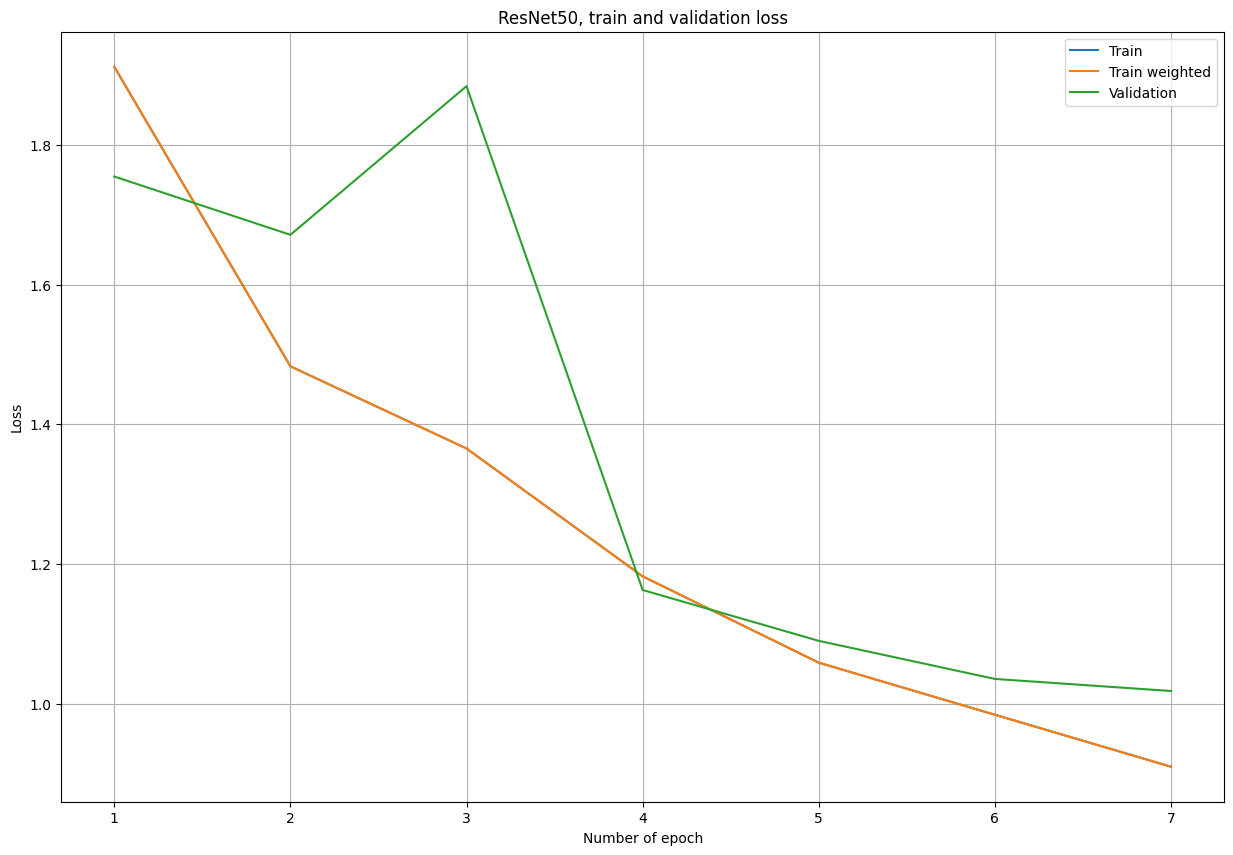

In [ ]:
plt.figure(figsize=(15, 10))
plt.title('ResNet50, train and validation loss')
plt.xlabel('Number of epoch')
plt.ylabel('Loss')

epochs = np.arange(len(callback.train_loss)) + 1
plt.plot(epochs, callback.train_loss , label='Train')
plt.plot(epochs, callback.train_w_loss , label='Train weighted')
plt.plot(epochs, callback.val_loss , label='Validation')
plt.legend()
plt.grid(True)


In [ ]:
print(f'Best loss on train: {np.min(callback.train_loss)}, on {np.argmin(callback.train_loss) + 1} epoch')
print(f'Best weighted loss on train: {np.min(callback.train_w_loss)}, on {np.argmin(callback.train_w_loss) + 1} epoch')
print(f'Best loss on validation: {np.min(callback.val_loss)}, on {np.argmin(callback.val_loss) + 1} epoch')

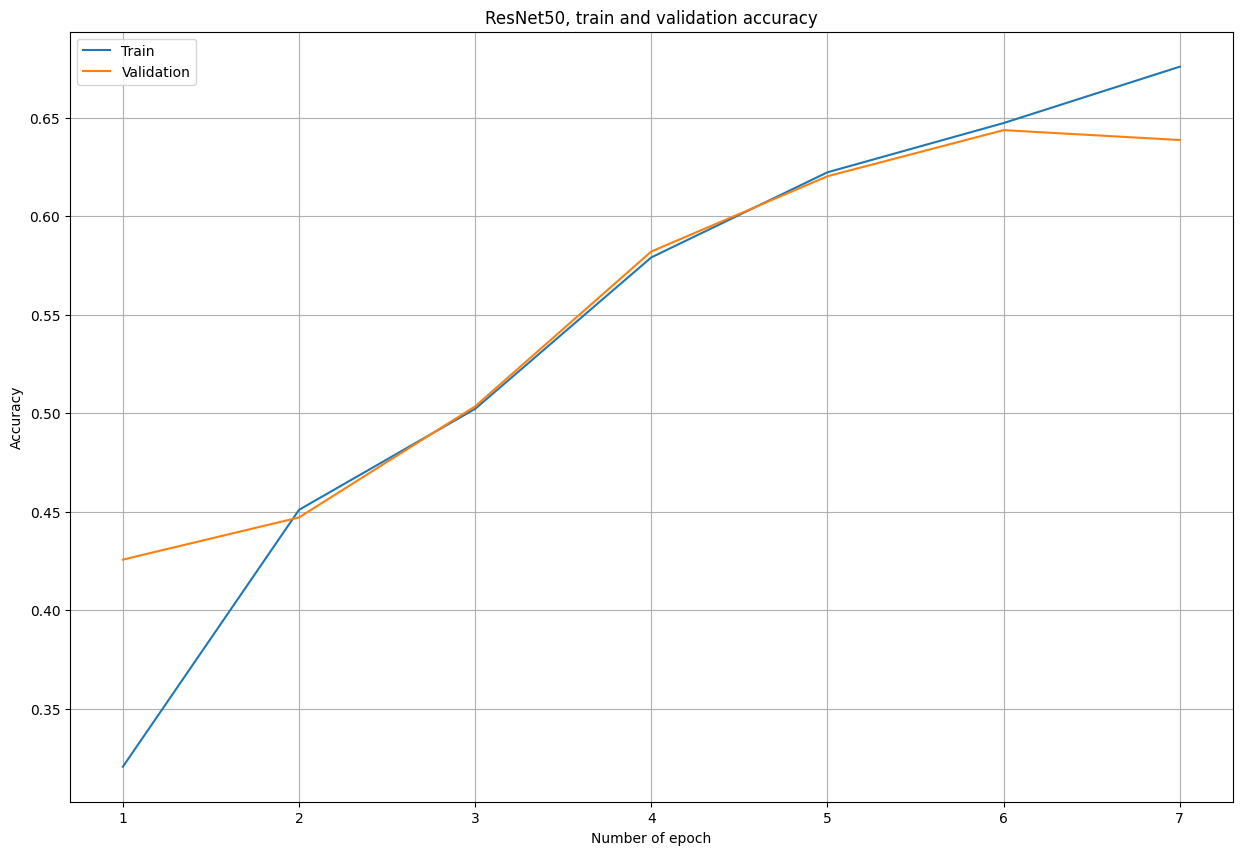

In [ ]:
plt.figure(figsize=(15, 10))
plt.title('ResNet50, train and validation accuracy')
plt.xlabel('Number of epoch')
plt.ylabel('Accuracy')
epochs = np.arange(len(callback.train_acc)) + 1
plt.plot(epochs, callback.train_acc, label='Train')
plt.plot(epochs, callback.val_acc , label='Validation')
plt.legend()
plt.grid(True)

In [ ]:
print(f'Best accuracy on train: {np.max(callback.train_acc)}, on {np.argmax(callback.train_acc) + 1} epoch')
print(f'Best accuracy on validation: {np.max(callback.val_acc)}, on {np.argmax(callback.val_acc) + 1} epoch')